# Machine Learning for Drug Discovery 2024
### Solubility
The code in this notebook is written to solve one of the problems from a hackathon at Machine Learning for Drug Discovery Summer School in Montreal in 2024. The benchmark is from polaris. Polaris is a hub for computational drug discovery benchmarks.

First, we import necessary packages. You might need to install polaris

**pip install polaris-lib**

In [1]:
from rdkit import Chem
import matplotlib.pyplot as plt
import polaris as po
import numpy as np

One of the benchmarks from the Polaris hub for the Log solubility problem containing 1578 training and 400 test points. It's a regression task. The info about this set can be found here: https://polarishub.io/benchmarks/polaris/adme-fang-solu-1

Before loading you might need to register by running the following command

**polaris login**

In [2]:
benchmark1 = po.load_benchmark("polaris/adme-fang-solu-1")

2024-07-09 21:25:25.911 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-07-09 21:25:25.936 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [3]:
train, test = benchmark1.get_train_test_split()
print (train.inputs[0])
print (train.targets[0])

CCNc1ccnc(N(C)Cc2nc3ccccc3n2C)n1
1.567849451


The descriptors/features are in the form of SMILEs and the targets are real numbers.

We will draw a few molecules from the training set

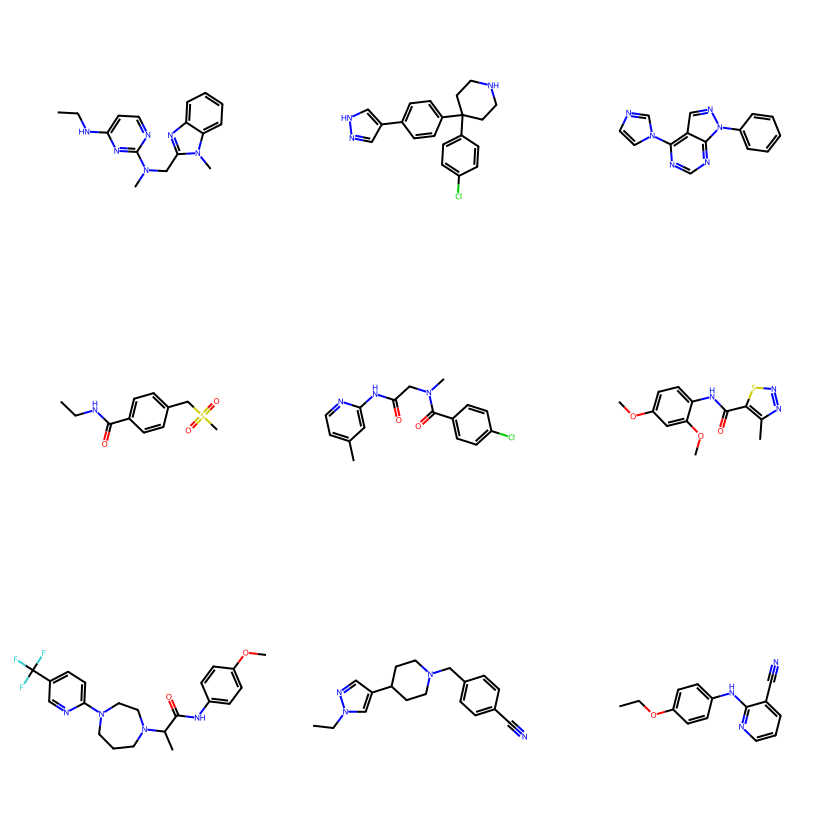

In [4]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in train.inputs[:9]]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(280, 280))

We will also draw a few molecules from the test set

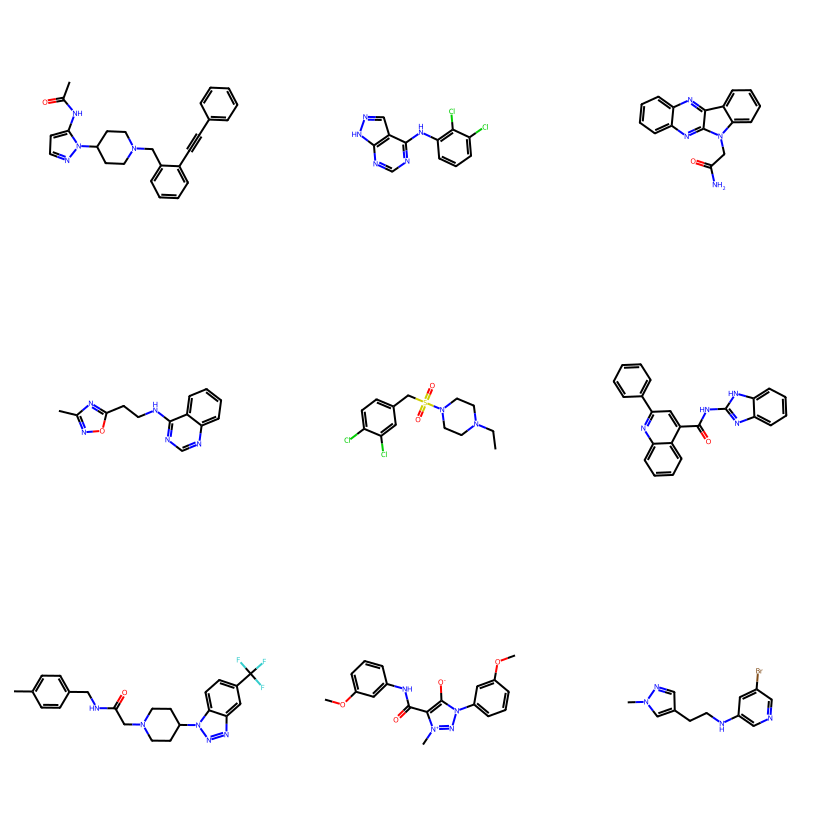

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in test.inputs[:9]]
Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(280, 280))

The training and test set molecules look quite similar.

Now we will plot the histogram of the target values from the training set. As we can see, it is quite far from the normal distribution.

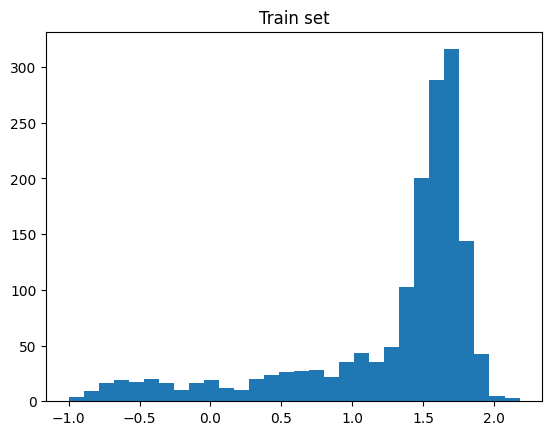

In [6]:
plt.hist(train.targets, bins=30)
plt.title("Train set")
plt.show()

Let's transform it to the distribution that looks more like a normal one with the help of Box-Cox transformation.

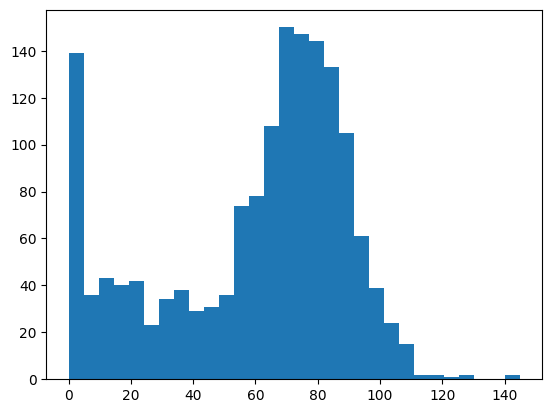

In [7]:
from scipy.stats import boxcox

z = train.targets + 2.0
bcx_target, lam = boxcox(z)
plt.hist(bcx_target, bins=30)
plt.show()

Unfortunately, we cannot plot the histogram for the test set, because within Polaris you should not need to access the targets of the test set. So, we cannot transform both sets.

Now we will turn our attention to the RDKit package. The example of the code below is from here: https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
It calculates all availabe RDKit descriptors and places them into a dictionary.

In [8]:
from rdkit.Chem import Descriptors

def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            # import traceback
            # traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

The line below is necessary to suppress warnings.

In [9]:
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')

We will now calculate all available RDKit descriptors for the training set.

In [10]:
train_mols = [Chem.MolFromSmiles(smi) for smi in train.inputs]
train_descriptors = [getMolDescriptors(m) for m in train_mols]

Now we will convert the list with all calculated descriptors into a dataframe.

In [11]:
import pandas as pd
df_train = pd.DataFrame(train_descriptors)
df_train.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.686612,4.686612,0.653530,0.653530,0.783367,10.863636,296.378,276.218,296.174945,114,...,0,0,0,0,0,0,0,0,0,0
1,6.098624,6.098624,0.060283,0.060283,0.743355,16.875000,337.854,317.694,337.134575,122,...,0,0,0,0,0,0,0,0,0,0
2,4.416519,4.416519,0.772853,0.772853,0.554060,11.000000,262.276,252.196,262.096694,96,...,0,0,0,0,0,0,0,0,0,0
3,11.411849,11.411849,0.002656,-3.021049,0.854365,11.125000,241.312,226.192,241.077264,88,...,0,0,1,0,0,0,0,0,0,0
4,12.185210,12.185210,0.058451,-0.302858,0.942814,10.136364,317.776,301.648,317.093104,114,...,0,0,0,0,0,0,0,0,0,0


It looks like there are a lot of columns with zeros, but we will first convert the dataframe to a numpy array.

In [12]:
train_features = df_train.to_numpy()
print (train_features)
print (train_features.shape)

[[ 4.6866121   4.6866121   0.65353009 ...  0.          0.
   0.        ]
 [ 6.09862377  6.09862377  0.06028282 ...  0.          0.
   0.        ]
 [ 4.41651927  4.41651927  0.77285289 ...  0.          0.
   0.        ]
 ...
 [12.84257203 12.84257203  0.0405953  ...  0.          0.
   0.        ]
 [13.10110447 13.10110447  0.11432238 ...  0.          1.
   0.        ]
 [12.23523613 12.23523613  0.03158229 ...  0.          0.
   0.        ]]
(1578, 210)


Let's now remove the columns with zeros.

In [13]:
train_features_clean = train_features[:,~np.all(train_features == 0, axis = 0)]
print (train_features_clean)
print (train_features_clean.shape)

[[ 4.6866121   4.6866121   0.65353009 ...  0.          0.
   0.        ]
 [ 6.09862377  6.09862377  0.06028282 ...  0.          0.
   0.        ]
 [ 4.41651927  4.41651927  0.77285289 ...  0.          0.
   0.        ]
 ...
 [12.84257203 12.84257203  0.0405953  ...  0.          0.
   0.        ]
 [13.10110447 13.10110447  0.11432238 ...  0.          1.
   0.        ]
 [12.23523613 12.23523613  0.03158229 ...  0.          0.
   0.        ]]
(1578, 189)


There are now 189 columns instead of 210.

Let's do the same with the test set. First, we will calculate all descriptors.

In [14]:
test_mols = [Chem.MolFromSmiles(smi) for smi in test.inputs]
test_descriptors = [getMolDescriptors(m) for m in test_mols]

Now we convert the list with the calculated descriptors into a dataframe.

In [15]:
df_test = pd.DataFrame(test_descriptors)
df_test.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.405628,11.405628,0.067217,-0.067217,0.674019,14.700000,398.510,372.302,398.210661,152,...,0,0,0,0,0,0,0,0,0,0
1,6.106953,6.106953,0.453170,0.453170,0.754554,10.777778,280.118,273.062,279.007851,90,...,0,0,0,0,0,0,0,0,0,0
2,11.370839,11.370839,0.094279,-0.395730,0.609762,11.428571,276.299,264.203,276.101111,102,...,0,0,0,0,0,0,0,0,0,0
3,5.055840,5.055840,0.628113,0.628113,0.767717,10.789474,255.281,242.177,255.112010,96,...,0,0,0,0,0,0,0,0,0,0
4,12.377568,12.377568,0.031732,-3.292703,0.847457,18.350000,337.272,319.128,336.046604,112,...,0,1,0,0,0,0,0,0,0,0


We can see, that there are also 210 columns. Let's convert the dataframe to a numpy array.

In [16]:
test_features = df_test.to_numpy()
print (test_features)
print (test_features.shape)

[[11.4056278  11.4056278   0.06721745 ...  0.          0.
   0.        ]
 [ 6.10695334  6.10695334  0.45317019 ...  0.          0.
   0.        ]
 [11.37083869 11.37083869  0.09427934 ...  0.          0.
   0.        ]
 ...
 [12.40702145 12.40702145  0.08615457 ...  0.          0.
   0.        ]
 [14.75938246 14.75938246  0.06034979 ...  0.          0.
   0.        ]
 [12.60770172 12.60770172  0.02180237 ...  0.          0.
   0.        ]]
(400, 210)


Let's now remove the columns with zeros.

In [17]:
test_features_clean = test_features[:,~np.all(test_features == 0, axis = 0)]
print (test_features_clean)
print (test_features_clean.shape)

[[11.4056278  11.4056278   0.06721745 ...  0.          0.
   0.        ]
 [ 6.10695334  6.10695334  0.45317019 ...  0.          0.
   0.        ]
 [11.37083869 11.37083869  0.09427934 ...  0.          0.
   0.        ]
 ...
 [12.40702145 12.40702145  0.08615457 ...  0.          0.
   0.        ]
 [14.75938246 14.75938246  0.06034979 ...  0.          0.
   0.        ]
 [12.60770172 12.60770172  0.02180237 ...  0.          0.
   0.        ]]
(400, 182)


As we can see, the number of columns (182) is now different from the training set array (189). So, we should use another approach. We will first detect all columns in both arrays with zeros with the help of the argwhere function.

In [18]:
idx_train = np.argwhere(np.all(train_features[..., :] == 0, axis=0))
print (idx_train.T)

idx_test = np.argwhere(np.all(test_features[..., :] == 0, axis=0))
print (idx_test.T)

[[ 10  69  82 147 156 157 158 160 162 163 164 174 175 178 186 188 192 193
  197 199 206]]
[[ 10  69  82 137 138 147 148 149 156 157 158 160 162 163 164 168 171 174
  175 178 184 185 186 192 193 197 199 206]]


Now we unite both the training and test sets of columns with zeros.

In [19]:
common_idx = list(set(idx_train.flatten()) & set(idx_test.flatten()))
print (common_idx)
print (len(common_idx))

[10, 147, 156, 157, 158, 160, 162, 163, 164, 174, 175, 178, 186, 192, 193, 69, 197, 199, 206, 82]
20


We will now transform both numpy arrays that will be used as our features in statistical models.

In [20]:
train_X = np.delete(train_features, common_idx, axis=1)
print (train_X)
print (train_X.shape)

[[ 4.6866121   4.6866121   0.65353009 ...  0.          0.
   0.        ]
 [ 6.09862377  6.09862377  0.06028282 ...  0.          0.
   0.        ]
 [ 4.41651927  4.41651927  0.77285289 ...  0.          0.
   0.        ]
 ...
 [12.84257203 12.84257203  0.0405953  ...  0.          0.
   0.        ]
 [13.10110447 13.10110447  0.11432238 ...  0.          1.
   0.        ]
 [12.23523613 12.23523613  0.03158229 ...  0.          0.
   0.        ]]
(1578, 190)


In [21]:
test_X = np.delete(test_features, common_idx, axis=1)
print (test_X)
print (test_X.shape)

[[11.4056278  11.4056278   0.06721745 ...  0.          0.
   0.        ]
 [ 6.10695334  6.10695334  0.45317019 ...  0.          0.
   0.        ]
 [11.37083869 11.37083869  0.09427934 ...  0.          0.
   0.        ]
 ...
 [12.40702145 12.40702145  0.08615457 ...  0.          0.
   0.        ]
 [14.75938246 14.75938246  0.06034979 ...  0.          0.
   0.        ]
 [12.60770172 12.60770172  0.02180237 ...  0.          0.
   0.        ]]
(400, 190)


Below is the code for the fitting our data with the Gradient Boosting Decision Trees algorithm, which returns the R2 score. It accepts three hyperparameters: the number of estimators, the max depth of trees and the learning rate as well as the random state.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

def GBoost_r2(train_X, train_y, test_X, n_est, max_d, learn_r, rand_st):
    model = GradientBoostingRegressor(n_estimators=n_est, max_depth=max_d, learning_rate=learn_r, random_state=rand_st)
    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    results = benchmark1.evaluate(y_pred)

    for k, item in enumerate(results.results['Metric']):
        if str(item) == 'Metric.r2':
            return results, results.results['Score'][k]
    return results, None

Here is an example for 30 estimators, max depth of 5 and learning rate 0.12.

In [23]:
rgb, r2_score_rgb = GBoost_r2(train_X, train.targets, test_X, 30, 5, 0.12, 777)
print (30, 5, 0.12, r2_score_rgb)

30 5 0.12 0.30134412733394234


It might not be the best result. Therefore, the hyperparameters need to be optimized. Below is a simple genetic algorithm for the optimization of hyperparameters of the Gradient Boosting model.

In [24]:
def GA_for_GBoost_r2(train_X, train_y, test_X, population_size = 16, n_steps = 10, to_print = False):
    # hyperparameters
    npop = population_size
    n_estimators_1 = 15
    n_estimators_2 = 150
    max_depth_1 = 3
    max_depth_2 = 12
    learning_rate_1 = -0.6 # it will be used as an exponent
    learning_rate_2 = -1.6 # it will be used as an exponent

    estimators_limits = (5, 200)
    depth_limits = (2, 20)
    learning_rate_limits = (-2.0, 0.0)

    # calculate initial score
    _, score1 = GBoost_r2(train_X, train_y, test_X, n_estimators_1, max_depth_1, 10**learning_rate_1, 777)
    _, score2 = GBoost_r2(train_X, train_y, test_X, n_estimators_2, max_depth_2, 10**learning_rate_2, 777)

    best_value = max(score1, score1)
    r2_list = list()

    if score1 > score2:
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
    else:
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))

    # start the optimization
    for i in range(n_steps):
        print('iter %d. reward: %f' % (i, best_value))

        pop_estimators = generate_population(n_estimators_1, n_estimators_2, estimators_limits, npop)
        pop_depth = generate_population(max_depth_1, max_depth_2, depth_limits, npop)
        pop_learning_rate = generate_population(learning_rate_1, learning_rate_2, learning_rate_limits, npop)

        R = np.zeros(npop)
        for j in range(npop):
            _, R[j] = GBoost_r2(train_X, train_y, test_X, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], 777)
            if to_print: print (j, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], R[j])

        Z = [(x, y, z) for _, x, y, z in sorted(zip(R, pop_estimators, pop_depth, pop_learning_rate), key=lambda pair: pair[0])]

        n_estimators_1 = Z[-1][0]
        n_estimators_2 = Z[-2][0]

        max_depth_1 = Z[-1][1]
        max_depth_2 = Z[-2][1]

        learning_rate_1 = Z[-1][2]
        learning_rate_2 = Z[-2][2]

        if np.max(R) > best_value:
            best_value = np.max(R)
            r2_list.append((best_value, n_estimators_1, max_depth_1, learning_rate_1))
        else:
            n_estimators_2 = r2_list[-1][1]
            max_depth_2 = r2_list[-1][2]
            learning_rate_2 = r2_list[-1][3]

    return best_value, r2_list

We need to generate a population for the genetic algorithm. We will do it based on two "parents" and also randomly apply "mutations". If the parents are integers, the population will also consits of integer numbers.

In [25]:
import random

def generate_population(parent1, parent2, limits, npop):
    population = []

    for k in range(npop):
        p = random.random()
        mated_val = parent1 * p + parent2 * (1 - p) # mating
            
        if random.random() < 0.2:
            mated_val = mated_val * (0.7 + 0.6 * random.random()) # mutation
                
        if mated_val < limits[0]:
            mated_val = limits[0]
        elif mated_val > limits[1]:
            mated_val = limits[1]

        if isinstance(parent1, int) and isinstance(parent2, int):
            mated_val = int(mated_val)
                
        child = mated_val

        population.append(child)
       
    return population

Let's run GA for 10 steps.

In [26]:
best_value, r2score_list = GA_for_GBoost_r2(train_X, train.targets, test_X, to_print = False)

iter 0. reward: 0.282339
iter 1. reward: 0.319341
iter 2. reward: 0.319341
iter 3. reward: 0.319341
iter 4. reward: 0.319341
iter 5. reward: 0.322083
iter 6. reward: 0.329254
iter 7. reward: 0.329254
iter 8. reward: 0.329254
iter 9. reward: 0.329254


In [27]:
print (r2score_list[-1])

(0.32925404065733344, 96, 6, -1.0820717515610512)


Now we rerun `GBoost_r2` with the optimized hyperparameters.

In [28]:
rgb, r2_score_rgb = GBoost_r2(train_X, train.targets, test_X, r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], 777)
print (r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], r2_score_rgb)
print (rgb)

96 6 0.08278053873127103 0.32925404065733344
name=None description='' tags=[] user_attributes={} owner=None polaris_version='dev' results=  Test set    Target label                      Metric     Score
0     test  LOG_SOLUBILITY  Metric.mean_absolute_error  0.413915
1     test  LOG_SOLUBILITY   Metric.mean_squared_error  0.363664
2     test  LOG_SOLUBILITY                   Metric.r2  0.329254
3     test  LOG_SOLUBILITY            Metric.spearmanr  0.468675
4     test  LOG_SOLUBILITY             Metric.pearsonr  0.575157
5     test  LOG_SOLUBILITY        Metric.explained_var  0.330118 benchmark_name='adme-fang-SOLU-1' benchmark_owner=HubOwner(slug='polaris', external_id='org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu', type='organization') github_url=None paper_url=None contributors=None artifact_id=None benchmark_artifact_id='polaris/adme-fang-solu-1'


## Conclusion

The best results for the **Gradient Boosting Decision Trees** algorithm and **RDKit** fingerprints, **R2 = 0.329254**, are obtained with the following hyperparameters: n_estimators = 96, max_depth = 6, learning_rate = 0.08278053873127103.

It is noticeably better than the best result with Morgan fingerprints (**R2 = 0.281718**).

In the next Jypyter notebooks we will explore the performance of mordred descriptors with the Gradient Boosting Decision Trees algorithm.